In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


In [3]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_1.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 9 nodes.
gmshTranslator: Mesh has 9 elements.
gmshTranslator: Processed 22 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [4]:
N_LGL = 8
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)
Lp_xi  = Li_xi.copy()
Lq_eta = Lj_eta.copy()

gmshTranslator: Ending


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [5]:
xi_ij  = af.np_to_af_array(np.array(af.flat(Xi)))
eta_ij = af.np_to_af_array(np.array(af.flat(Eta)))

In [6]:
dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_ij_interp, eta_ij_interp)
dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_ij_interp, eta_ij_interp)
deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_ij_interp, eta_ij_interp)
deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_ij_interp, eta_ij_interp)

NameError: name 'xi_ij_interp' is not defined

In [ ]:
def F_xi(u):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    return F_eta_u

In [ ]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [ ]:
N_LGL_interp = N_LGL + 1
xi_LGL_interp  = lagrange.LGL_points(N_LGL_interp)
eta_LGL_interp = lagrange.LGL_points(N_LGL_interp)
Xi_interp, Eta_interp = utils.af_meshgrid(xi_LGL_interp, eta_LGL_interp)

_, Li_xi_interp  = lagrange.lagrange_polynomials(xi_LGL_interp)
_, Lj_eta_interp = lagrange.lagrange_polynomials(eta_LGL_interp)

Li_xi_interp  = af.np_to_af_array(Li_xi_interp)
Lj_eta_interp = af.np_to_af_array(Lj_eta_interp)
Lp_xi_interp  = Li_xi_interp.copy()
Lq_eta_interp = Lj_eta_interp.copy()

In [ ]:
xi_ij_interp  = af.np_to_af_array(np.array(af.flat(Xi_interp)))
eta_ij_interp = af.np_to_af_array(np.array(af.flat(Eta_interp)))

In [57]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_ij_interp, eta_ij_interp)

In [58]:
u_ij_interp = np.e ** (- (xi_ij_interp**2) / (0.4 ** 2))

u_ij_tile_interp = af.moddims(u_ij_interp, N_LGL_interp, N_LGL_interp)

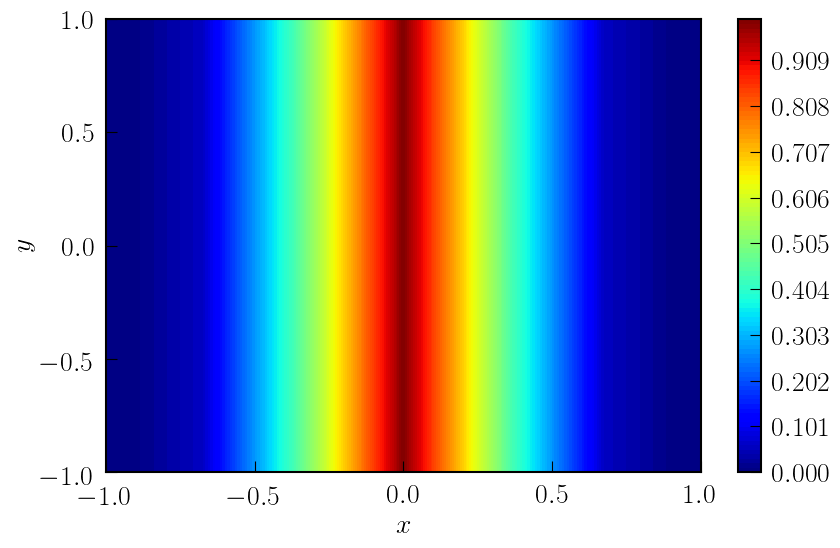

In [59]:
color_levels = np.linspace(0., 1., 100)
plt.contourf(np.array(Xi_interp), np.array(Eta_interp), np.array(u_ij_tile_interp),200, levels = color_levels, cmap = 'jet')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.show()

In [60]:
# print(Lq_eta)
Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile = af.tile(Lp_xi_tile, d0 = N_LGL)
Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile = af.tile(Lq_eta_tile, d0 = N_LGL)
Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)

In [64]:
Lp_xi_tile_interp = af.reorder(Lq_eta_interp, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile_interp = af.tile(Lp_xi_tile_interp, d0 = N_LGL_interp)
Lp_xi_tile_interp = af.moddims(Lp_xi_tile_interp, d0 = N_LGL_interp * N_LGL_interp, d1 = 1, d2 = N_LGL_interp)
Lp_xi_tile_interp = af.reorder(Lp_xi_tile_interp, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tile_interp = af.reorder(Lq_eta_interp, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile_interp = af.tile(Lq_eta_tile_interp, d0 = N_LGL_interp)
Lq_eta_tile_interp = af.reorder(Lq_eta_tile_interp, d0 = 0, d1 = 2, d2 = 1)


In [65]:
dLp_dxi_tile  = utils.polynomial_derivative(Lp_xi_tile)
dLq_deta_tile = utils.polynomial_derivative(Lq_eta_tile)

In [66]:
F_xi_ij_interp     = F_xi(xi_ij_interp)
F_eta_ij_interp    = F_eta(eta_ij_interp)
Lp_ij_interp       = af.transpose(utils.polyval_1d(Lp_xi_tile[0], af.np_to_af_array(np.array(xi_ij_interp))))
Lq_ij_interp       = af.transpose(utils.polyval_1d(Lq_eta_tile[0], af.np_to_af_array(np.array(eta_ij_interp))))
dLp_dxi_ij_interp  = af.transpose(utils.polyval_1d(dLp_dxi_tile[0], af.np_to_af_array(np.array(xi_ij_interp))))
dLq_deta_ij_interp = af.transpose(utils.polyval_1d(dLq_deta_tile[0], af.np_to_af_array(np.array(eta_ij_interp))))

In [67]:
integrand_ij = g_ab[0][0] * Lq_ij_interp * dLp_dxi_ij_interp * F_xi_ij_interp

In [70]:
print(af.sum(integrand_ij * utils.integrate_2d(Lp_xi_tile_interp, Lq_eta_tile_interp, order = 9, scheme = 'gauss')))

0.03443877551071037
